# Exploratory Data Analysis (EDA) Report
This section is a complete EDA workflow for the Goodreads dataset you loaded from PostgreSQL (`raw_data`).
It is organized into small chunks (quality checks → cleaning → exploration → visuals), so you can run cell-by-cell and see results as you go.

# Dataset
the dataset is about goodreads books information like (book name, author, description, genres, average rating number of ratings and the URL to the goodreads page of the book)

It has 10,000 entries

In [ ]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import os
from dotenv import load_dotenv, find_dotenv

dotenv_path = find_dotenv(usecwd=True)
if dotenv_path:
    load_dotenv(dotenv_path)
    print(f"✅ Loaded .env from: {dotenv_path}")
else:
    print("⚠️ .env not found (using existing environment variables)")

DB_HOST = os.getenv("POSTGRES_HOST")
DB_NAME = os.getenv("POSTGRES_DB")
DB_USER = os.getenv("POSTGRES_USER")
DB_PASS = os.getenv("POSTGRES_PASSWORD")
DB_PORT = os.getenv("POSTGRES_PORT", "5432")

# 1. SETUP CONNECTION=
DATABASE_URL = f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(DATABASE_URL)

# 2. QUERY THE DATA
# We select everything from the table you just filled.
query = "SELECT * FROM raw_data;"

# 3. LOAD INTO DATAFRAME
df_raw = pd.read_sql(query, engine)

# 4. VERIFY
print(f"✅ Data Loaded! Shape: {df_raw.shape}")
df_raw.head()

✅ Loaded .env from: d:\TCC\Project 1\.env
✅ Data Loaded! Shape: (10000, 9)


,id,book,author,description,genres,avg_rating,num_ratings_raw,url,loaded_at
0,0,To Kill a Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sl...,"['Classics', 'Fiction', 'Historical Fiction', ...",4.27,"5,691,311",https://www.goodreads.com/book/show/2657.To_Ki...,2026-02-09 07:59:29.469211+00:00
1,1,Harry Potter and the Philosopher’s Stone (Harr...,J.K. Rowling,Harry Potter thinks he is an ordinary boy - un...,"['Fantasy', 'Fiction', 'Young Adult', 'Magic',...",4.47,"9,278,135",https://www.goodreads.com/book/show/72193.Harr...,2026-02-09 07:59:29.469211+00:00
2,2,Pride and Prejudice,Jane Austen,"Since its immediate success in 1813, Pride and...","['Classics', 'Fiction', 'Romance', 'Historical...",4.28,"3,944,155",https://www.goodreads.com/book/show/1885.Pride...,2026-02-09 07:59:29.469211+00:00
3,3,The Diary of a Young Girl,Anne Frank,Discovered in the attic in which she spent the...,"['Classics', 'Nonfiction', 'History', 'Biograp...",4.18,"3,488,438",https://www.goodreads.com/book/show/48855.The_...,2026-02-09 07:59:29.469211+00:00
4,4,Animal Farm,George Orwell,Librarian's note: There is an Alternate Cover ...,"['Classics', 'Fiction', 'Dystopia', 'Fantasy',...",3.98,"3,575,172",https://www.goodreads.com/book/show/170448.Ani...,2026-02-09 07:59:29.469211+00:00


## Dataset info
Now im going to explore the dataset to prepare it for processing

In [142]:
print(f"Dataset Shape: {df_raw.shape}")
print("\n--- Missing Values ---")
print(df_raw.isnull().sum())

print("\n--- Data Types ---")
print(df_raw.dtypes)


Dataset Shape: (10000, 9)

--- Missing Values ---
id                  0
book                0
author              0
description        77
genres              0
avg_rating          0
num_ratings_raw     0
url                 0
loaded_at           0
dtype: int64

--- Data Types ---
id                               int64
book                            object
author                          object
description                     object
genres                          object
avg_rating                     float64
num_ratings_raw                 object
url                             object
loaded_at          datetime64[ns, UTC]
dtype: object


- As shown up there is 77 null values in description 

In [143]:
# count missing/empty genres
missing_genres = df_raw["genres"].isna() | (df_raw["genres"].astype(str).str.strip().isin(["", "[]"]))
print(f"Missing/empty genres rows: {missing_genres.sum()}")

# Build a per-genre Series (skip missing/empty)
s = (
    df_raw.loc[~missing_genres, "genres"]
    .astype(str)
    .str.strip("[]")
    .str.replace("'", "", regex=False)
)

all_genres = (
    s.str.split(r"\s*,\s*", regex=True)
     .explode()
     .str.strip()
)

# remove accidental empties
all_genres = all_genres[all_genres.ne("")]

genre_counts = all_genres.value_counts()

print(f"Unique genres: {genre_counts.size}")
genre_counts.head()

Missing/empty genres rows: 960
Unique genres: 617


genres
Fiction       5700
Nonfiction    2330
Fantasy       2195
Classics      2123
Romance       1558
Name: count, dtype: int64

- there is 960 entries that does not have genres at all

## Visualaization

from now on i will start visualizing the raw data for analyzation

### TOP 20 genres
this code will visual the top 20 genres and their counts on books

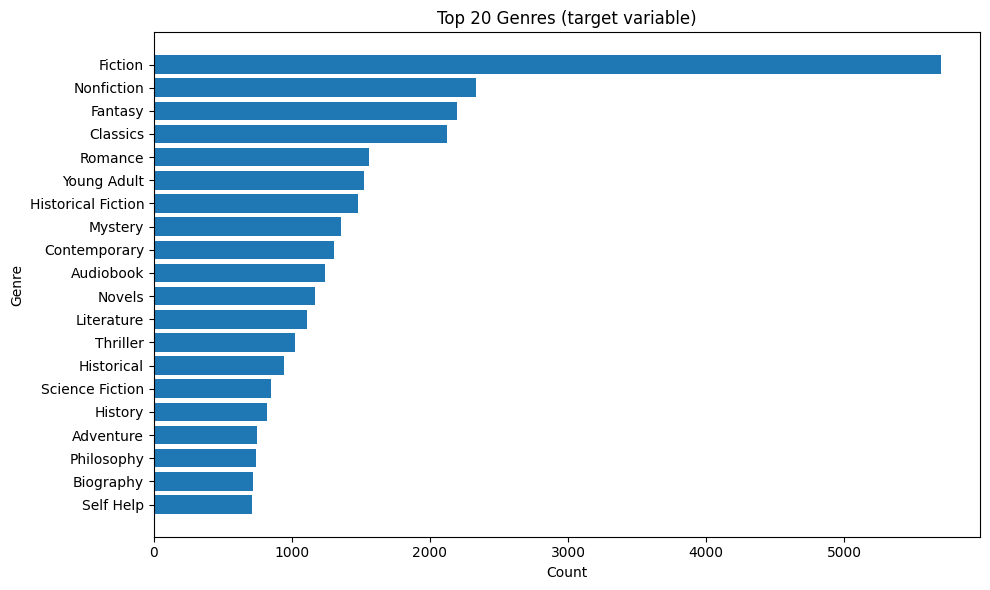

In [144]:
from matplotlib import pyplot as plt
# Top 20 genres (from the raw 'genres' column)
missing_genres = df_raw["genres"].isna() | (df_raw["genres"].astype(str).str.strip().isin(["", "[]"]))

s = (
    df_raw.loc[~missing_genres, "genres"]
    .astype(str)
    .str.strip()
    .str.strip("[]")
    .str.replace("'", "", regex=False)
    .str.replace('"', "", regex=False)
 )

all_genres = (
    s.str.split(r"\s*,\s*", regex=True)
     .explode()
     .str.strip()
 )

all_genres = all_genres[all_genres.ne("")]
top20 = all_genres.value_counts().head(20)

plt.figure(figsize=(10, 6))
plt.barh(top20.index[::-1], top20.values[::-1])
plt.title("Top 20 Genres (target variable)")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()


- As shown the dataset turns a lot to the fiction genre

### Exploring missing or null genres
as the genre our target variable to predict, this section visualize the missing, empty or has genre books number

Missing (NaN) rows: 0
Empty-like rows: 960
Total rows: 10000


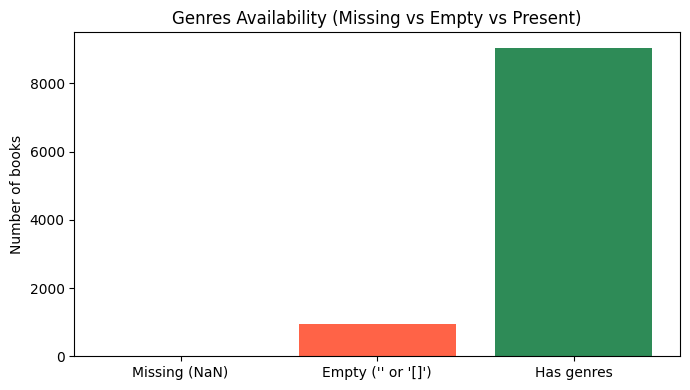

In [145]:


# 1) Separate masks
genres_stripped = df_raw["genres"].astype(str).str.strip()

missing_mask = df_raw["genres"].isna()                        # truly NaN/NULL
empty_mask = (~missing_mask) & genres_stripped.isin(["", "[]"])  # present but empty-like

print("Missing (NaN) rows:", int(missing_mask.sum()))
print("Empty-like rows:", int(empty_mask.sum()))
print("Total rows:", len(df_raw))

# 2) Plot missing vs empty vs has genres
counts = pd.Series(
    {
        "Missing (NaN)": int(missing_mask.sum()),
        "Empty ('' or '[]')": int(empty_mask.sum()),
        "Has genres": int((~missing_mask & ~empty_mask).sum()),
    }
)

plt.figure(figsize=(7, 4))
plt.bar(counts.index, counts.values, color=["orange", "tomato", "seagreen"])
plt.title("Genres Availability (Missing vs Empty vs Present)")
plt.ylabel("Number of books")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Correlation between description length and number of genres length
this visualaization explore the relation between number of words in description to the same book's number of genres


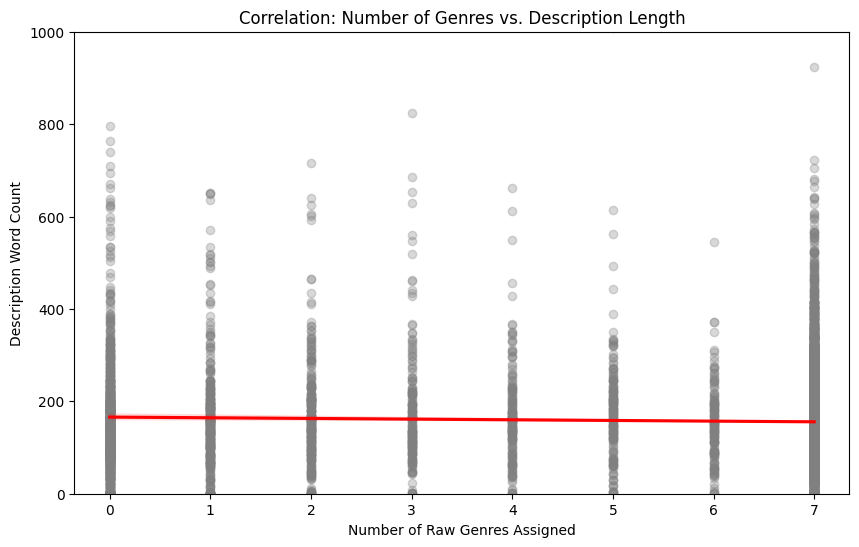

In [146]:
import seaborn as sns
import ast
# Parse genres to count them
def count_genres(genre_str):
    try:
        return len(ast.literal_eval(genre_str))
    except:
        return 0

df_raw['num_genres'] = df_raw['genres'].apply(count_genres)
df_raw['desc_words'] = df_raw['description'].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.regplot(data=df_raw, x='num_genres', y='desc_words', 
            scatter_kws={'alpha':0.3, 'color':'gray'}, 
            line_kws={'color':'red'})

plt.title('Correlation: Number of Genres vs. Description Length')
plt.xlabel('Number of Raw Genres Assigned')
plt.ylabel('Description Word Count')
plt.ylim(0, 1000)
plt.show()

- As shown the longer the description does not need to have more genres

### Missing values
this code will view visual the missing values as yellew lines

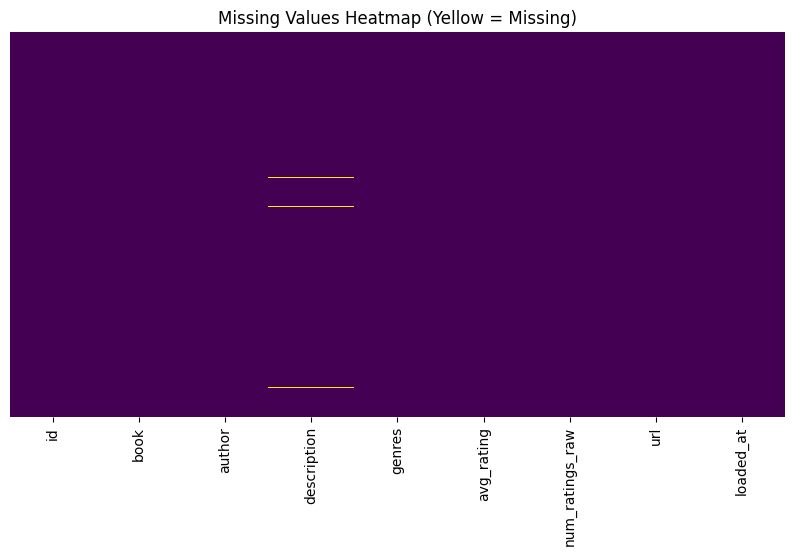

In [147]:
df_raw = df_raw.drop(columns=['num_genres','desc_words'])

plt.figure(figsize=(10, 5))
sns.heatmap(df_raw.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap (Yellow = Missing)')
plt.show()

### Number of words 
this visualizastion view the number of words in book title and bokk description, its average and the shortest book description

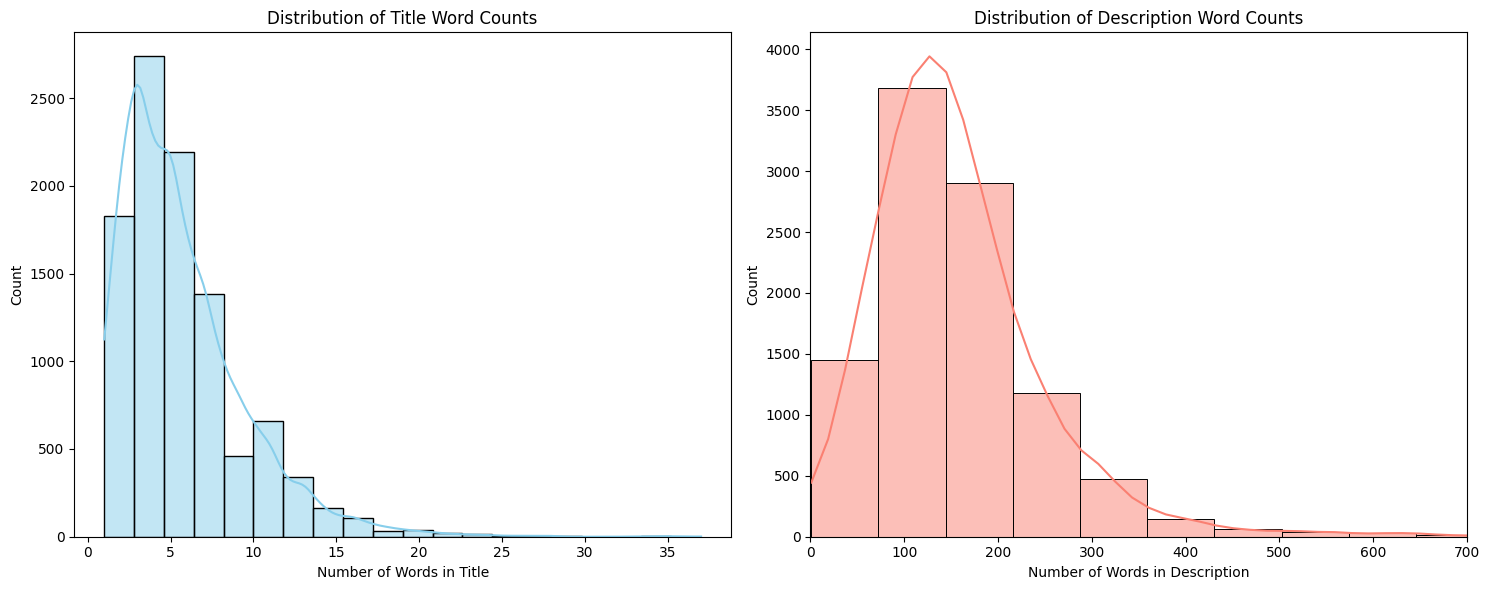

Shortest Description: 1 words
Longest Description: 3583 words
Average Description Length: 157.4 words
Average Title Length: 5.7 words


In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate word counts for inputs
df_raw['title_words'] = df_raw['book'].astype(str).apply(lambda x: len(x.split()))
df_raw['desc_words'] = df_raw['description'].astype(str).apply(lambda x: len(x.split()))

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(df_raw['title_words'], bins=20, kde=True, ax=ax[0], color='skyblue')
ax[0].set_title('Distribution of Title Word Counts')
ax[0].set_xlabel('Number of Words in Title')

sns.histplot(df_raw['desc_words'], bins=50, kde=True, ax=ax[1], color='salmon')
ax[1].set_title('Distribution of Description Word Counts')
ax[1].set_xlabel('Number of Words in Description')
ax[1].set_xlim(0, 700) # Zooming in on the bulk of data

plt.tight_layout()
plt.show()

print(f"Shortest Description: {df_raw['desc_words'].min()} words")
print(f"Longest Description: {df_raw['desc_words'].max()} words")
print(f"Average Description Length: {df_raw['desc_words'].mean():.1f} words")
print(f"Average Title Length: {df_raw['title_words'].mean():.1f} words")

### Number of books that has < 10 words descritpion
this section visualize the number of books that has 1-10 words count as description

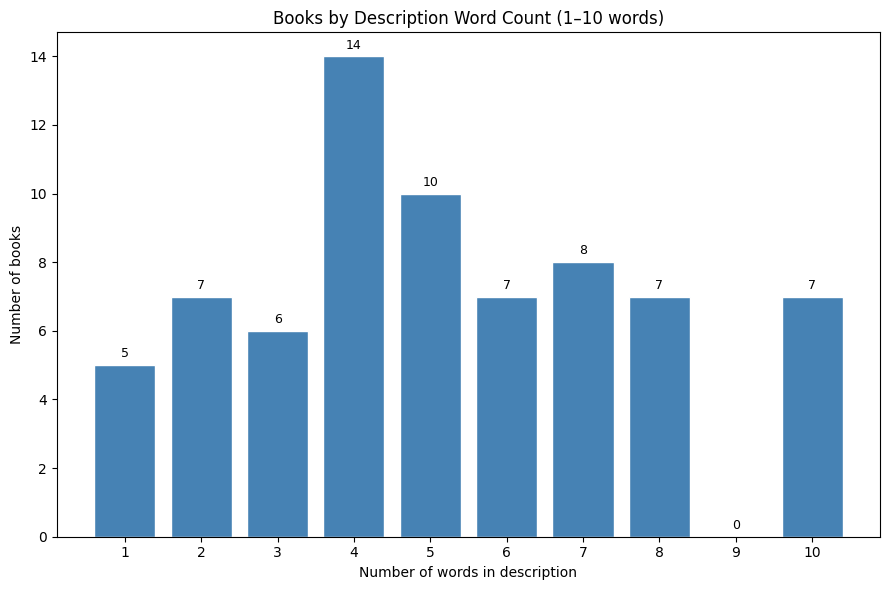

Total books with 1–10 word descriptions: 71


In [149]:
# 1) word-count for descriptions (robust to NaN / punctuation)
df_tmp = df_raw.copy()
df_tmp["description"] = df_tmp["description"].fillna("").astype(str).str.strip()
df_tmp["desc_words"] = df_tmp["description"].str.findall(r"\b\w+\b").str.len()

# 2) counts for descriptions with 1..10 words
counts_1_10 = (
    df_tmp.loc[df_tmp["desc_words"].between(1, 10), "desc_words"]
    .value_counts()
    .reindex(range(1, 11), fill_value=0)
    .sort_index()
)

# 3) bar chart
plt.figure(figsize=(9, 6))
plt.bar(counts_1_10.index.astype(str), counts_1_10.values, color="steelblue", edgecolor="white")
plt.title("Books by Description Word Count (1–10 words)")
plt.xlabel("Number of words in description")
plt.ylabel("Number of books")
for i, v in enumerate(counts_1_10.values):
    plt.text(i, v + max(counts_1_10.values) * 0.01, str(int(v)), ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

# 4) list the books for each word count (1..10)
total_books_1_to_10 = int(df_tmp["desc_words"].between(1, 10).sum())
print(f"Total books with 1–10 word descriptions: {total_books_1_to_10}")


- As shown there is about 71 books that does have < 10 words description which is not actual description, some may have urls some may have "see info" or the author name

### Most common words 
this visualization explore most common words in book titles and book descriptions

C:\Users\ysula\AppData\Local\Temp\ipykernel_17792\2674715167.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), ax=ax, palette=color)
C:\Users\ysula\AppData\Local\Temp\ipykernel_17792\2674715167.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), ax=ax, palette=color)


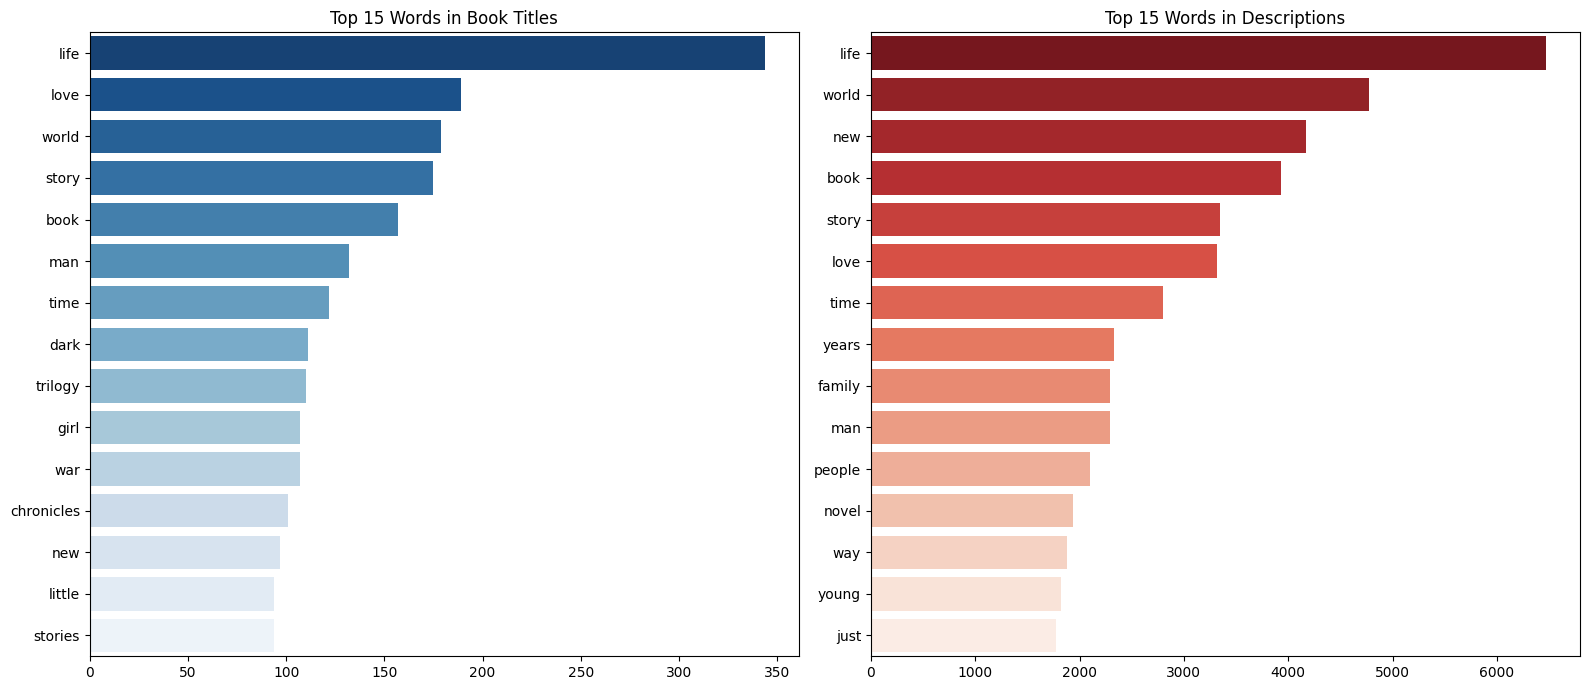

In [150]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_words(column_name, title, color, ax):
    # Remove NaN values for the text analysis
    text_data = df_raw[column_name].dropna().astype(str)
    
    # Using simple CountVectorizer to get top unigrams (single words)
    vec = CountVectorizer(stop_words='english', max_features=15).fit(text_data)
    bag_of_words = vec.transform(text_data)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    words, counts = zip(*words_freq)
    sns.barplot(x=list(counts), y=list(words), ax=ax, palette=color)
    ax.set_title(title)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

plot_top_words('book', 'Top 15 Words in Book Titles', 'Blues_r', axes[0])
plot_top_words('description', 'Top 15 Words in Descriptions', 'Reds_r', axes[1])

plt.tight_layout()
plt.show()

# Preprocessing

## Removing empty genre rows
my goal is to predict genre from book title and descriptions so, having empty genres will compromise the model

In [151]:
# Remove rows with missing OR empty-like genres ("", "[]")

genres_stripped = df_raw["genres"].astype(str).str.strip()

missing_mask = df_raw["genres"].isna()
empty_mask = (~missing_mask) & genres_stripped.isin(["", "[]"])

to_drop = missing_mask | empty_mask

print("Rows before:", len(df_raw))
print("Dropping (missing or empty genres):", int(to_drop.sum()))

df_raw_clean = df_raw.loc[~to_drop].copy()

print("Rows after:", len(df_raw_clean))
df_raw_clean.head()

Rows before: 10000
Dropping (missing or empty genres): 960
Rows after: 9040


,id,book,author,description,genres,avg_rating,num_ratings_raw,url,loaded_at,title_words,desc_words
0,0,To Kill a Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sl...,"['Classics', 'Fiction', 'Historical Fiction', ...",4.27,"5,691,311",https://www.goodreads.com/book/show/2657.To_Ki...,2026-02-09 07:59:29.469211+00:00,4,137
1,1,Harry Potter and the Philosopher’s Stone (Harr...,J.K. Rowling,Harry Potter thinks he is an ordinary boy - un...,"['Fantasy', 'Fiction', 'Young Adult', 'Magic',...",4.47,"9,278,135",https://www.goodreads.com/book/show/72193.Harr...,2026-02-09 07:59:29.469211+00:00,9,43
2,2,Pride and Prejudice,Jane Austen,"Since its immediate success in 1813, Pride and...","['Classics', 'Fiction', 'Romance', 'Historical...",4.28,"3,944,155",https://www.goodreads.com/book/show/1885.Pride...,2026-02-09 07:59:29.469211+00:00,3,100
3,3,The Diary of a Young Girl,Anne Frank,Discovered in the attic in which she spent the...,"['Classics', 'Nonfiction', 'History', 'Biograp...",4.18,"3,488,438",https://www.goodreads.com/book/show/48855.The_...,2026-02-09 07:59:29.469211+00:00,6,166
4,4,Animal Farm,George Orwell,Librarian's note: There is an Alternate Cover ...,"['Classics', 'Fiction', 'Dystopia', 'Fantasy',...",3.98,"3,575,172",https://www.goodreads.com/book/show/170448.Ani...,2026-02-09 07:59:29.469211+00:00,2,123


### Grouping genres
as shown previously there is 617 unique genre and that is way too much so, i though about grouping books into 3 genres [fiction, non-fiction, historical]

In [152]:
# 1) parse "['Fantasy', 'Romance']" into ["Fantasy","Romance"] WITHOUT ast
def split_genres(x):
    if pd.isna(x):
        return []
    text = str(x).strip()
    text = text.strip("[]").replace("'", "")   # remove brackets + quotes
    parts = [p.strip() for p in text.split(",")]
    return [p for p in parts if p]             # drop empty

# 2) define your buckets (edit as you like)
FICTION_TAGS = {
    "Fiction", "Fantasy", "Science Fiction", "Science Fiction Fantasy", "Dystopia",
    "Historical Fiction", "Literary Fiction",
    "Magical Realism", 
}


def genre_group(genres_list):
    gset = set(genres_list)

    # Rule 1: any fiction-ish tag => Fiction
    if gset & FICTION_TAGS:
        return "Fiction"

    # Rule 2: otherwise => Nonfiction
    return "Nonfiction"

# Apply
df_raw_clean["genre_list"] = df_raw_clean["genres"].apply(split_genres)  # change if column name differs
df_raw_clean["genre_group"] = df_raw_clean["genre_list"].apply(genre_group)

print(df_raw_clean["genre_group"].value_counts())

# keep only what you need
df_grouped = df_raw_clean.copy()   # contains every column that exists in df_raw_clean
print("df_grouped shape:", df_grouped.shape)

genre_group
Fiction       6123
Nonfiction    2917
Name: count, dtype: int64
df_grouped shape: (9040, 13)


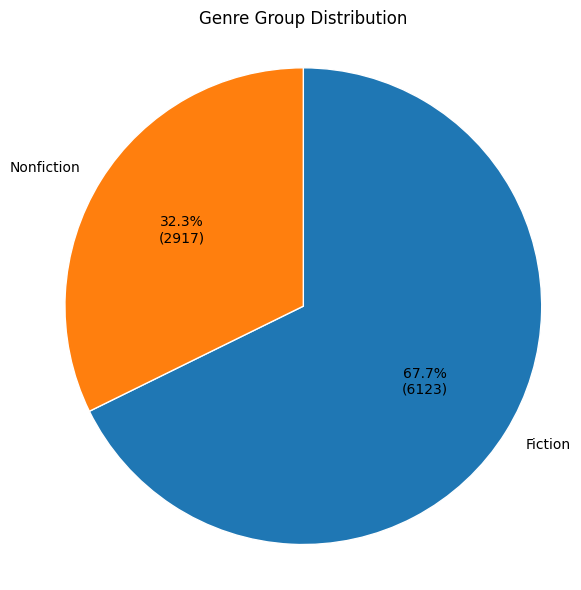

In [153]:
group_counts = df_grouped["genre_group"].value_counts()

total = int(group_counts.sum())

def autopct_with_counts(pct):
    count = int(round(pct * total / 100.0))
    return f"{pct:.1f}%\n({count})"

plt.figure(figsize=(6, 6))
plt.pie(
    group_counts.values,
    labels=group_counts.index,
    autopct=autopct_with_counts,
    startangle=90,
    counterclock=False,
    textprops={"fontsize": 10},
    wedgeprops={"edgecolor": "white"},
)
plt.title("Genre Group Distribution")
plt.axis("equal")  # make it a circle
plt.tight_layout()
plt.show()

### Removing unintended columns

In [154]:
# Keep only these columns (and drop everything else)
keep_cols = ["id","book", "description", "genre_group"]


df_grouped = df_grouped[keep_cols].copy()
print("New shape:", df_grouped.shape)
df_grouped.head()

New shape: (9040, 4)


,id,book,description,genre_group
0,0,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,Fiction
1,1,Harry Potter and the Philosopher’s Stone (Harr...,Harry Potter thinks he is an ordinary boy - un...,Fiction
2,2,Pride and Prejudice,"Since its immediate success in 1813, Pride and...",Fiction
3,3,The Diary of a Young Girl,Discovered in the attic in which she spent the...,Nonfiction
4,4,Animal Farm,Librarian's note: There is an Alternate Cover ...,Fiction


### Removing less than 10 words books descriptions

In [155]:
df_filtered = df_grouped.copy()  # change to df_raw / df_final if you prefer

# robust word count (handles NaN + punctuation)
desc = df_filtered["description"].fillna("").astype(str).str.strip()
df_filtered["desc_words"] = desc.str.findall(r"\b\w+\b").str.len()

print("Rows before:", len(df_filtered))
df_filtered = df_filtered[df_filtered["desc_words"] >= 10].copy()
print("Rows after (desc_words >= 10):", len(df_filtered))

print(df_filtered["genre_group"].value_counts())
# optional: drop helper column
df_final = df_filtered.drop(columns=["desc_words"])
df_final.head()

Rows before: 9040
Rows after (desc_words >= 10): 8951
genre_group
Fiction       6080
Nonfiction    2871
Name: count, dtype: int64


,id,book,description,genre_group
0,0,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,Fiction
1,1,Harry Potter and the Philosopher’s Stone (Harr...,Harry Potter thinks he is an ordinary boy - un...,Fiction
2,2,Pride and Prejudice,"Since its immediate success in 1813, Pride and...",Fiction
3,3,The Diary of a Young Girl,Discovered in the attic in which she spent the...,Nonfiction
4,4,Animal Farm,Librarian's note: There is an Alternate Cover ...,Fiction


### Merging book title and description columns
the title book usually has indications to book content so, i am adding it to the description to have them both as indicators of genre

In [156]:
# Create a merged text column (book + description)
df_final["book_desc"] = (
    df_final["book"].fillna("").astype(str).str.strip()
    + " "
    + df_final["description"].fillna("").astype(str).str.strip()
).str.strip()

df_final = df_final.drop(columns=["book", "description"])
df_final.head()


,id,genre_group,book_desc
0,0,Fiction,To Kill a Mockingbird The unforgettable novel ...
1,1,Fiction,Harry Potter and the Philosopher’s Stone (Harr...
2,2,Fiction,Pride and Prejudice Since its immediate succes...
3,3,Nonfiction,The Diary of a Young Girl Discovered in the at...
4,4,Fiction,Animal Farm Librarian's note: There is an Alte...


### Sending data frame to database
Ingesting processed and ready to train data to database

In [157]:
from sqlalchemy import inspect
from sqlalchemy import MetaData, Table
from sqlalchemy.dialects.postgresql import insert as pg_insert

df = df_final.where(pd.notnull(df_final), None)

column_map = {
    'Unnamed: 0':  'id',
    'genre_group':        'genre_group',
    'book_desc':       'description',
}

# Apply the mapping
df = df.rename(columns=column_map)

# Only keep columns that actually exist in the SQL table
expected_columns = ['id', 'genre_group', 'description']
df = df[expected_columns]

# ==========================================
# 4. EXECUTION (Load Data)
# ==========================================
try:
    inspector = inspect(engine)
    if not inspector.has_table('processed_data'):
        print("❌ ERROR: Table 'processed_data' does not exist.")
        raise SystemExit(1)

    # Insert rows; ignore duplicates by primary key (id)
    metadata = MetaData()
    raw_table = Table('processed_data', metadata, autoload_with=engine)

    table_cols = {c.name for c in raw_table.columns}
    insert_cols = [c for c in df.columns if c in table_cols]
    if 'id' not in insert_cols:
        raise ValueError("Table 'processed_data' must have an 'id' column.")

    inserted_total = 0
    chunk_size = 1000
    for start in range(0, len(df), chunk_size):
        chunk = df.iloc[start:start + chunk_size][insert_cols]
        rows = chunk.to_dict(orient='records')
        if not rows:
            continue

        stmt = (
            pg_insert(raw_table)
            .values(rows)
            .on_conflict_do_nothing(index_elements=['id'])
        )

        with engine.begin() as conn:
            result = conn.execute(stmt)
            if result.rowcount is not None:
                inserted_total += result.rowcount
    if inserted_total == 0:
        print("⚠️ No new rows were inserted; all data may already exist in 'proccessed_data'.") 
    else:
        print(f"✅ SUCCESS: Loaded into 'proccessed_data' (inserted {inserted_total} new rows; duplicates ignored).")
except Exception as e:
    print(f"❌ ERROR: {e}")

✅ SUCCESS: Loaded into 'proccessed_data' (inserted 8951 new rows; duplicates ignored).


# Modeling

## Load data from SQL

In [158]:
query = "SELECT * FROM processed_data;"

# 3. LOAD INTO DATAFRAME
df = pd.read_sql(query, engine)

# 4. VERIFY
print(f"✅ Data Loaded! Shape: {df.shape}")
df = df.drop(columns=['id'])
df.head()

✅ Data Loaded! Shape: (8951, 3)


,genre_group,description
0,Fiction,To Kill a Mockingbird The unforgettable novel ...
1,Fiction,Harry Potter and the Philosopher’s Stone (Harr...
2,Fiction,Pride and Prejudice Since its immediate succes...
3,Nonfiction,The Diary of a Young Girl Discovered in the at...
4,Fiction,Animal Farm Librarian's note: There is an Alte...


## Preparing the data for training

First the data is a natural language so it needs nlp preprocessing like:

1- lower case text

2- remove urls

3- remove numbers

4- remove extra whitespaces

5- lemmatize the words

In [159]:
import nltk
from nltk.corpus import stopwords
import regex as re

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)

lemmatizer = nltk.stem.WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove URLs
    text = re.sub(r"[^\w\s]", '', text)  # remove punctuation
    text = re.sub(r"\d+", '', text)  # remove numbers
    text = re.sub(r"\s+", ' ', text).strip()  # remove extra whitespace
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words] #Remove stop words and stem
    return ' '.join(words)

preprocess_text("this is a sample description! It including numbers 123 and punctuation... like   playing    doing box , stats and status ")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ysula\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'sample description including number punctuation like playing box stats status'

## Baseline model (dummy)
baseline model for classification task (Majority predict model), takes the unproccessed data and predict on majority

              precision    recall  f1-score   support

     Fiction       0.68      1.00      0.81      1217
  Nonfiction       0.00      0.00      0.00       574

    accuracy                           0.68      1791
   macro avg       0.34      0.50      0.40      1791
weighted avg       0.46      0.68      0.55      1791



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


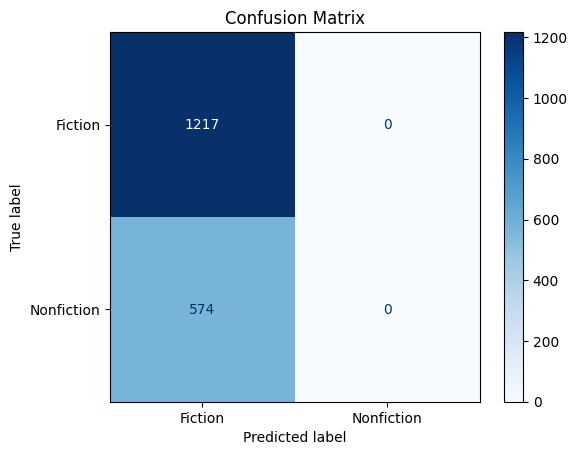

In [160]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# Your data
texts = df_final["book_desc"]   # documents
labels = df_final["genre_group"]  # Fiction / Nonfiction

# Split
dummy_X_train, dummy_X_test, dummy_y_train, dummy_y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# Majority class model
baseline = DummyClassifier(strategy="most_frequent")

# Train (it just learns the most common label)
baseline.fit(dummy_X_train, dummy_y_train)

# Predict
dummyy_pred = baseline.predict(dummy_X_test)

# Evaluate
print(classification_report(dummy_y_test, dummyy_pred))
cm = confusion_matrix(dummy_y_test, dummyy_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fiction", "Nonfiction"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

## Improved model

### Vectorization
I will use Tf-Idf as vectoraizatio as it is the best vectoraization method for it give more weight to important words

In [161]:
from sklearn.feature_extraction.text import TfidfVectorizer
df_final['processed_text'] = df_final['book_desc'].apply(preprocess_text)   

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df_final['processed_text'])

### Prepare for training
prepare tf-idf matrix and splitting the dataset

In [162]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

X = tfidf_matrix
df_final['genre_group'] = df_final['genre_group'].map({'Fiction': 1, 'Nonfiction': 0})
y = df_final["genre_group"]

# Split (use stratify to keep label proportions)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

df_final.head()

,id,genre_group,book_desc,processed_text
0,0,1,To Kill a Mockingbird The unforgettable novel ...,kill mockingbird unforgettable novel childhood...
1,1,1,Harry Potter and the Philosopher’s Stone (Harr...,harry potter philosopher stone harry potter ha...
2,2,1,Pride and Prejudice Since its immediate succes...,pride prejudice since immediate success pride ...
3,3,0,The Diary of a Young Girl Discovered in the at...,diary young girl discovered attic spent last y...
4,4,1,Animal Farm Librarian's note: There is an Alte...,animal farm librarian note alternate cover edi...


### LinearSVC classifier
LinearSVC is effective because it finds the optimal geometric boundary—the widest margin—between Fiction and Nonfiction. By focusing on key “support vector” words rather than simple counts, and combined with TF-IDF weighting, it robustly captures subtle linguistic differences, especially improving performance on challenging Nonfiction cases where recall currently lags.

Cross-Validation Scores: [0.8961474  0.88994413 0.89832402 0.85642458 0.86648045]
Mean Cross-Validation Score: 0.8815

Model Evaluation (Test Set)
Accuracy: 0.8883

Classification Report:
              precision    recall  f1-score   support

  Nonfiction       0.87      0.77      0.82       574
     Fiction       0.90      0.94      0.92      1217

    accuracy                           0.89      1791
   macro avg       0.88      0.86      0.87      1791
weighted avg       0.89      0.89      0.89      1791



<Figure size 700x600 with 0 Axes>

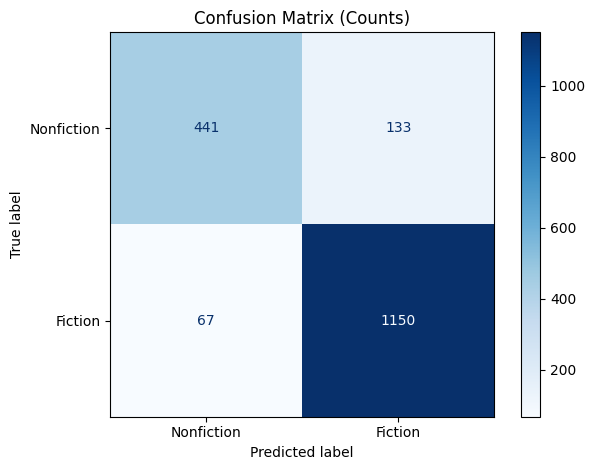

In [163]:
from sklearn.svm import LinearSVC

svm_classifier = LinearSVC(random_state=42, C=1.0, class_weight='balanced')
svm_classifier.fit(X_train, y_train)

svm_y_pred = svm_classifier.predict(X_test)

# Evaluation
# y is encoded as: Fiction=1, Nonfiction=0
labels_order = sorted(y.unique())
label_name_map = {0: "Nonfiction", 1: "Fiction"}
target_names = [label_name_map.get(int(lbl), str(lbl)) for lbl in labels_order]

cv_scores = cross_val_score(svm_classifier, X, y, cv=5, scoring="accuracy")
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {np.mean(cv_scores):.4f}")

print("\nModel Evaluation (Test Set)")
print(f"Accuracy: {accuracy_score(y_test, svm_y_pred):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, svm_y_pred, labels=labels_order, target_names=target_names))

# Confusion matrix (COUNTS ONLY)
plt.figure(figsize=(7, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    svm_y_pred,
    labels=labels_order,
    display_labels=target_names,
    cmap="Blues",
    values_format="d",
 )
plt.title("Confusion Matrix (Counts)")
plt.tight_layout()
plt.show()

### Naive Bayes classifier
Naive Bayes works well here because it’s a fast, simple probabilistic method that efficiently handles thousands of unique words without heavy computation. It relies on word frequencies to identify key genre indicators, assumes word independence to avoid complexity, and remains stable even with noisy or irrelevant text in book descriptions.

Cross-Validation Scores: [0.85873814 0.87877095 0.8698324  0.83296089 0.82793296]
Mean Cross-Validation Score: 0.8536

Model Evaluation (Test Set)
Accuracy: 0.8543

Classification Report:
              precision    recall  f1-score   support

  Nonfiction       0.88      0.63      0.74       574
     Fiction       0.85      0.96      0.90      1217

    accuracy                           0.85      1791
   macro avg       0.86      0.80      0.82      1791
weighted avg       0.86      0.85      0.85      1791



<Figure size 700x600 with 0 Axes>

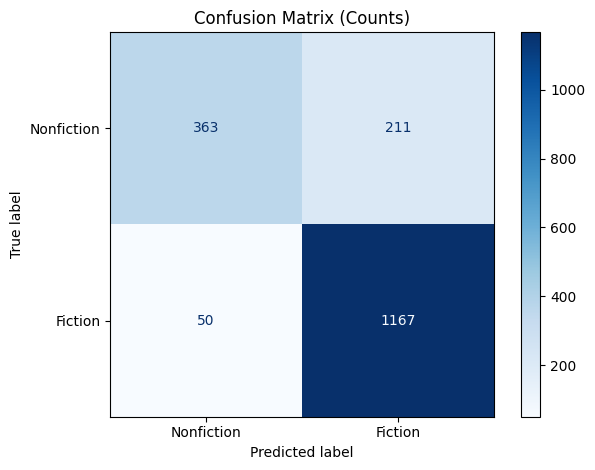

In [164]:
from sklearn.naive_bayes import MultinomialNB

naive_bayes_classifier = MultinomialNB(alpha=0.1)
naive_bayes_classifier.fit(X_train, y_train)

naive_bayes_y_pred = naive_bayes_classifier.predict(X_test)

# Evaluation
# y is encoded as: Fiction=1, Nonfiction=0
labels_order = sorted(y.unique())
label_name_map = {0: "Nonfiction", 1: "Fiction"}
target_names = [label_name_map.get(int(lbl), str(lbl)) for lbl in labels_order]

cv_scores = cross_val_score(naive_bayes_classifier, X, y, cv=5, scoring="accuracy")
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {np.mean(cv_scores):.4f}")

print("\nModel Evaluation (Test Set)")
print(f"Accuracy: {accuracy_score(y_test, naive_bayes_y_pred):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, naive_bayes_y_pred, labels=labels_order, target_names=target_names))

# Confusion matrix (COUNTS ONLY)
plt.figure(figsize=(7, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    naive_bayes_y_pred,
    labels=labels_order,
    display_labels=target_names,
    cmap="Blues",
    values_format="d",
 )
plt.title("Confusion Matrix (Counts)")
plt.tight_layout()
plt.show()

## Save Models


### SVC 

In [165]:
from sklearn.pipeline import Pipeline
import joblib
import pandas as pd

SVC_pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer), # Uses the vectorizer you already defined
    ('clf', svm_classifier)           # Uses the SVC you already trained
])

# Save the pipeline
# joblib.dump(SVC_pipeline, "SVC_pipeline.joblib")
# print("✅ Full pipeline saved!")

### Naive bayes

In [166]:
Naive_Bayes_pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('clf', naive_bayes_classifier)
])

# Save the pipeline
# joblib.dump(Naive_Bayes_pipeline, "Naive_Bayes_pipeline.joblib")
# print("✅ Full pipeline saved!")

# Mlflow 

### Preparing models and reports for logs

In [167]:
X_train, X_test, y_train, y_test = train_test_split(
    df_final['book_desc'], df_final['genre_group'], test_size=0.2)

models = [
    ("SVC", SVC_pipeline, (X_train, y_train), (X_test, y_test)),
    ("Naive Bayes", Naive_Bayes_pipeline, (X_train, y_train), (X_test, y_test))
]
      
reports =[]

for model_name, model, train_set, test_set in models:
    X_train = train_set[0]
    y_train = train_set[1]
    X_test = test_set[0]
    y_test = test_set[1]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append((model_name, report))


### Mlflow add models and register SVC


In [ ]:
import os
import mlflow
import mlflow.sklearn

# Tip for Docker MLflow: use a NEW experiment name so its artifact_location
# becomes `mlflow-artifacts:/` (proxy) instead of `file:/...`.
# Example: os.environ["MLFLOW_EXPERIMENT_NAME"] = "Book Genre Classification (Docker)"
os.environ["MLFLOW_EXPERIMENT_NAME"] = "Book Genre Classification (Docker)"
tracking_uri = os.getenv("MLFLOW_TRACKING_URI")
experiment_name = os.getenv("MLFLOW_EXPERIMENT_NAME", "Book Genre Classification")

mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment(experiment_name)

exp = mlflow.get_experiment_by_name(experiment_name)
print("MLFLOW_TRACKING_URI =", tracking_uri)
print("MLFLOW_EXPERIMENT_NAME =", experiment_name)
print("Experiment artifact_location =", getattr(exp, "artifact_location", None))

for i, element in enumerate(models):
   model_name = element[0]
   model = element[1]
   report = reports[i][1]
    
   with mlflow.start_run(run_name=model_name) as run:
         if "SVC" in model_name:
            mlflow.log_param("C", model.get_params()['clf__C'])
         elif "Naive" in model_name:
            mlflow.log_param("alpha", model.get_params()['clf__alpha'])
         mlflow.log_metrics({
            "accuracy": report["accuracy"],
            "precision_Fiction": report["1"]["precision"],
            "recall_Fiction": report["1"]["recall"],
            "f1-score_Fiction": report["1"]["f1-score"],
            "precision_Nonfiction": report["0"]["precision"],
            "recall_Nonfiction": report["0"]["recall"],
            "f1-score_Nonfiction": report["0"]["f1-score"],
         })
         artifact_path = model_name.replace(" ", "_") + "_model"
         mlflow.sklearn.log_model(model, artifact_path=artifact_path)

         if "SVC" in model_name:  # only register the SVC
            mlflow.register_model(
            model_uri=f"runs:/{run.info.run_id}/{artifact_path}",
            name="SVC_model"
               )  

2026/02/09 11:00:17 INFO mlflow.tracking.fluent: Experiment with name 'Book Genre Classification (Docker)' does not exist. Creating a new experiment.


MLFLOW_TRACKING_URI = http://127.0.0.1:5001/
MLFLOW_EXPERIMENT_NAME = Book Genre Classification (Docker)
Experiment artifact_location = mlflow-artifacts:/1


2026/02/09 11:00:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\ysula\AppData\Roaming\Python\Python312\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
Successfully registered model 'SVC_model'.
2026/02/09 11:00:29 WARNING mlflow.tracking._model_registry.fluent: Run with id 42be29dc5f2b4958930b6fcd1f6ccbc2 has no artifacts at artifact path 'SVC_model', registering model based on models:/m-3060115cd6e84a8ca190bde44477bc9f instead
2026/02/09 11:00:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SVC_model, ve

🏃 View run SVC at: http://127.0.0.1:5001/#/experiments/1/runs/42be29dc5f2b4958930b6fcd1f6ccbc2
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
🏃 View run Naive Bayes at: http://127.0.0.1:5001/#/experiments/1/runs/3b0b73affdcc44a8b60daf1a67187fb6
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
